In [1]:
import sys
sys.path.append("../src")
import torch
from collections import defaultdict
from models.trainable_model import TrainModel
from postprocessing.plots.plot_results import plot_pr_curves, plot_roc_curves
from utils.metrics.matrix_computer import MatrixComputer, compute_bin_matrices_px
from utils.metrics.metric_computer import MetricComputer
from utils.common.pathManager import FilePath 
from utils.dataloaders.train_dataloader import TrainDataLoader
from utils.datasets.train_dataset import TrainDataset
from utils.metrics.curve_computer import pixel_metric_curves
from utils.visualization.label_to_color import LabelDict

out_dir = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_50/out")
split_json = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_50/data/splits/sliced_splits.json")
mean_json = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_50/data/dataset_statistics/all_tiles_mean_stddev.json")

weights_path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_200/out/definitive_model/checkpoints/model_best.pth.tar")
metric_dir = out_dir.join('metrics').create_folder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model: TrainModel = TrainModel().to(device=device)
model.load_freezed_weights(weights_path, device)

xBD_test = TrainDataset('test', split_json, mean_json)
dis_id, tile_id, patch_id, patch = xBD_test[34]
x_pre = patch['pre_img'].unsqueeze(0).to(device=device)
x_post = patch['post_img'].unsqueeze(0).to(device=device)
y_cls = patch['dmg_mask'].unsqueeze(0).to(device=device)

masks = [(y_cls == lab_i) for lab_i in range(5)]
bin_true_tensor = torch.stack(masks, dim=0)
model.eval()
logit_masks = model(x_pre, x_post)[2]

n_class = 5
patch_conf_mtrx_dict = defaultdict(lambda: torch.zeros(size=(n_class, 4)))
for th in torch.linspace(0, 1, 50):
    bin_pred_tensor = model.softmax(logit_masks) >= th
    bin_pred_tensor = bin_pred_tensor.permute(1, 0, 2, 3)
    conf_matrices = compute_bin_matrices_px(bin_pred_tensor, bin_true_tensor)
    key = round(float(th), 5)
    patch_conf_mtrx_dict[key] += conf_matrices.to(device='cpu')

import matplotlib.pyplot as ax

ax.figure(figsize=(10, 10), dpi=100)

for label, (fpr, tpr, auc_value) in roc_curves.items():
    c = LabelDict().get_color_by_num(label)
    plt.plot(fpr, tpr, color=c, label=f'Class {label} (AUC = {auc_value:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
plt.subplots_adjust(left=0.1, right=0.6, top=0.6, bottom=0.1)
plt.legend(loc='lower right', fontsize=16, bbox_to_anchor=(1.7, 0))
plt.grid(True)
plt.show()

/home/mrtc101/Desktop/tesina/repo/main/notebooks/../src/models/trainable_model.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map

NameError: name 'roc_curves' is not defined

In [49]:
import sys

import matplotlib.axes
import numpy as np
sys.path.append("../src")
import matplotlib
import torch
from tqdm import tqdm, trange
from collections import defaultdict
from models.trainable_model import TrainModel
from postprocessing.plots.plot_results import plot_pr_curves, plot_roc_curves
from utils.metrics.matrix_computer import MatrixComputer
from utils.metrics.metric_computer import MetricComputer
from utils.common.pathManager import FilePath 
from utils.dataloaders.train_dataloader import TrainDataLoader
from utils.datasets.train_dataset import TrainDataset
from utils.metrics.curve_computer import pixel_metric_curves
from utils.visualization.label_to_color import LabelDict
%matplotlib inline

out_dir = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_50/out")
split_json = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_50/data/splits/sliced_splits.json")
mean_json = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_50/data/dataset_statistics/all_tiles_mean_stddev.json")

weights_path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exps/exp4_samp_200/out/definitive_model/checkpoints/model_best.pth.tar")
metric_dir = out_dir.join('metrics').create_folder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model: TrainModel = TrainModel().to(device=device)
model.load_freezed_weights(weights_path, device)

xBD_test = TrainDataset('test', split_json, mean_json)

n_class = 5
patch_conf_mtrx_dict = defaultdict(lambda: torch.zeros(size=(n_class, 4)))

for i in trange(25):
    dis_id, tile_id, patch_id, patch = xBD_test[i]
    x_pre = patch['pre_img'].unsqueeze(0).to(device=device)
    x_post = patch['post_img'].unsqueeze(0).to(device=device)
    y_cls = patch['dmg_mask'].unsqueeze(0).to(device=device)

    masks = [(y_cls == lab_i) for lab_i in range(5)]
    bin_true_tensor = torch.stack(masks, dim=0)

    logit_masks = model(x_pre, x_post)[2]

    for th in torch.linspace(0, 1, 6):
        bin_pred_tensor = model.softmax(logit_masks) >= th
        bin_pred_tensor = bin_pred_tensor.permute(1, 0, 2, 3)
        conf_matrices = compute_bin_matrices_px(bin_pred_tensor, bin_true_tensor)
        key = round(float(th), 5)
        patch_conf_mtrx_dict[key] += conf_matrices.to(device='cpu')

/home/mrtc101/Desktop/tesina/repo/main/notebooks/../src/models/trainable_model.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map

In [80]:
import pandas as pd
rows = [[tup[0]]+(list(tup[1][1].numpy().astype(int))) for tup in list(patch_conf_mtrx_dict.items())]
print(pd.DataFrame(data=rows, columns=["umbral","tp","fp","fn","tn"]))


   umbral     tp       fp     fn       tn
0     0.0  41403  1596997      0        0
1     0.2  37745  1596000   3658      997
2     0.4  35149     2422   6254  1594575
3     0.6  34625     2232   6778  1594765
4     0.8  33797     1809   7606  1595188
5     1.0      0        0  41403  1596997


In [70]:
from sklearn.metrics import auc


conf_dict = patch_conf_mtrx_dict
# Almacenar las curvas ROC para cada clase y umbral
curves = defaultdict(lambda: defaultdict(list))

for th, conf_tensor in conf_dict.items():
    for i_label in range(conf_tensor.shape[0]):
        tp, fp, fn, tn = map(float, conf_tensor[i_label])
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (tn + fp) > 0 else 0
        curves[i_label][th] = (fpr, tpr)  # FPR, TPR

# Calcular el AUC para cada curva ROC
roc_curves = {}
for label, th_curves in curves.items():
    x, y = zip(*sorted(th_curves.values()))  # Ordenar por FPR
    auc_value = auc(x, y)
    roc_curves[label] = (x, y, auc_value)

type = "pixel"
out = metric_dir

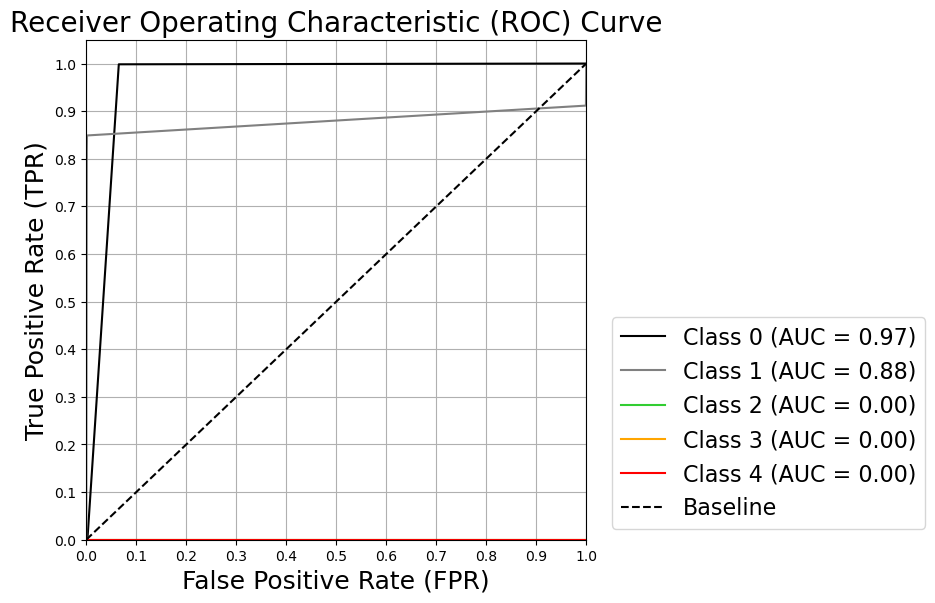

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax : matplotlib.axes.Axes
for label, (fpr, tpr, auc_value) in roc_curves.items():
    c = LabelDict().get_color_by_num(label)
    ax.plot(fpr, tpr, color=c, label=f'Class {label} (AUC = {auc_value:.2f})')

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xticks(np.arange(0, 1.1, step=0.1))
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_xlabel('False Positive Rate (FPR)', fontsize=18)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=18)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
fig.subplots_adjust(left=0.1, right=0.6, top=0.6, bottom=0.1)
ax.legend(loc='lower right', fontsize=16, bbox_to_anchor=(1.7, 0))
ax.grid(True)


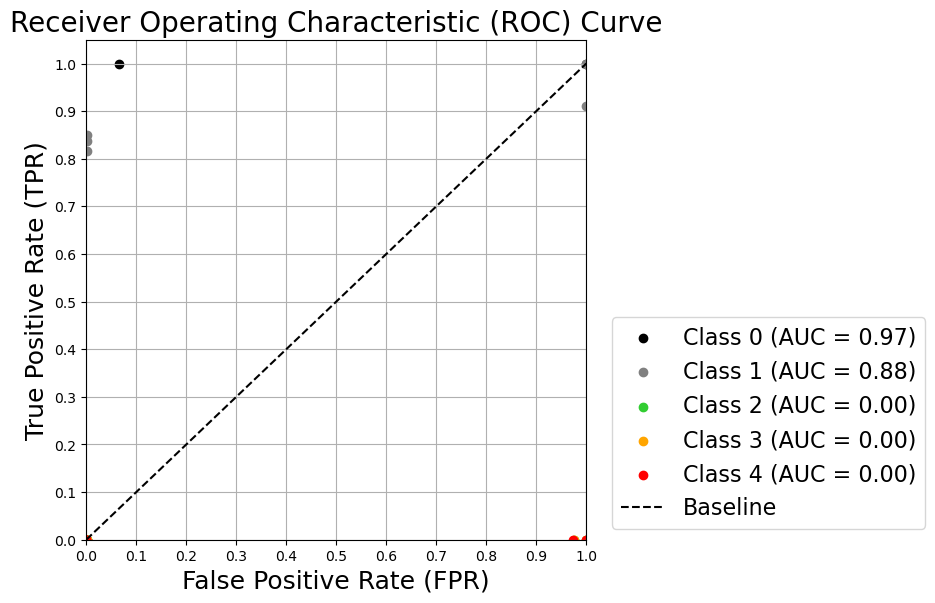

In [72]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax : matplotlib.axes.Axes
for label, (fpr, tpr, auc_value) in roc_curves.items():
    c = LabelDict().get_color_by_num(label)
    ax.scatter(fpr, tpr, color=c, label=f'Class {label} (AUC = {auc_value:.2f})')

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xticks(np.arange(0, 1.1, step=0.1))
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_xlabel('False Positive Rate (FPR)', fontsize=18)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=18)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
fig.subplots_adjust(left=0.1, right=0.6, top=0.6, bottom=0.1)
ax.legend(loc='lower right', fontsize=16, bbox_to_anchor=(1.7, 0))
ax.grid(True)


